In [29]:
pip install statsmodels

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import poisson, gamma
from statsmodels.tsa.seasonal import seasonal_decompose

In [31]:
df = pd.read_csv("data.csv", delimiter = ";", decimal = ",")
df

,Start,End,Registration,Amount,Amount Refunded,Days,Hours,Kilometers
0,2022-09-30 08:45,2022-09-30 12:00,ESP27B,320.26,0.0,0,3,22
1,2022-04-06 08:30,2022-04-06 16:00,ESP27B,617.50,0.0,0,7,40
2,2022-03-27 13:00,2022-03-27 17:15,FCE68C,559.51,0.0,0,4,106
3,2022-03-20 17:30,2022-03-20 22:00,MGD320,305.00,0.0,0,4,20
4,2022-03-20 09:00,2022-03-20 12:30,YTH92B,379.91,0.0,0,3,49
...,...,...,...,...,...,...,...,...
181,2022-05-15 11:30,2022-05-15 13:30,GOH58A,208.69,0.0,0,2,39
182,2022-04-29 11:00,2022-04-29 16:15,KKJ20F,500.69,0.0,0,5,83
183,2022-04-24 11:00,2022-04-24 13:00,PGP00J,251.00,0.0,0,2,43
184,2022-04-22 10:00,2022-04-22 17:00,UPG59G,623.50,0.0,0,7,44


In [32]:
df.columns = ["date_of_booking", "end_of_booking", "registration_number", "cost_of_booking", "amount_refunded", "days_rent", "hours_rent", "driven_kilometers"]
df

,date_of_booking,end_of_booking,registration_number,cost_of_booking,amount_refunded,days_rent,hours_rent,driven_kilometers
0,2022-09-30 08:45,2022-09-30 12:00,ESP27B,320.26,0.0,0,3,22
1,2022-04-06 08:30,2022-04-06 16:00,ESP27B,617.50,0.0,0,7,40
2,2022-03-27 13:00,2022-03-27 17:15,FCE68C,559.51,0.0,0,4,106
3,2022-03-20 17:30,2022-03-20 22:00,MGD320,305.00,0.0,0,4,20
4,2022-03-20 09:00,2022-03-20 12:30,YTH92B,379.91,0.0,0,3,49
...,...,...,...,...,...,...,...,...
181,2022-05-15 11:30,2022-05-15 13:30,GOH58A,208.69,0.0,0,2,39
182,2022-04-29 11:00,2022-04-29 16:15,KKJ20F,500.69,0.0,0,5,83
183,2022-04-24 11:00,2022-04-24 13:00,PGP00J,251.00,0.0,0,2,43
184,2022-04-22 10:00,2022-04-22 17:00,UPG59G,623.50,0.0,0,7,44


In [33]:
df["hours_rent"] = df.days_rent * 24 + df.hours_rent
df["total_cost_of_booking"] = df.cost_of_booking - df.amount_refunded
df["number_of_rents"] = 1

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_9088\2074969122.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  monthly_data = df.groupby(df['date_of_booking'].dt.to_period("M"))['total_cost_of_booking', 'driven_kilometers', 'hours_rent', 'number_of_rents'].sum()


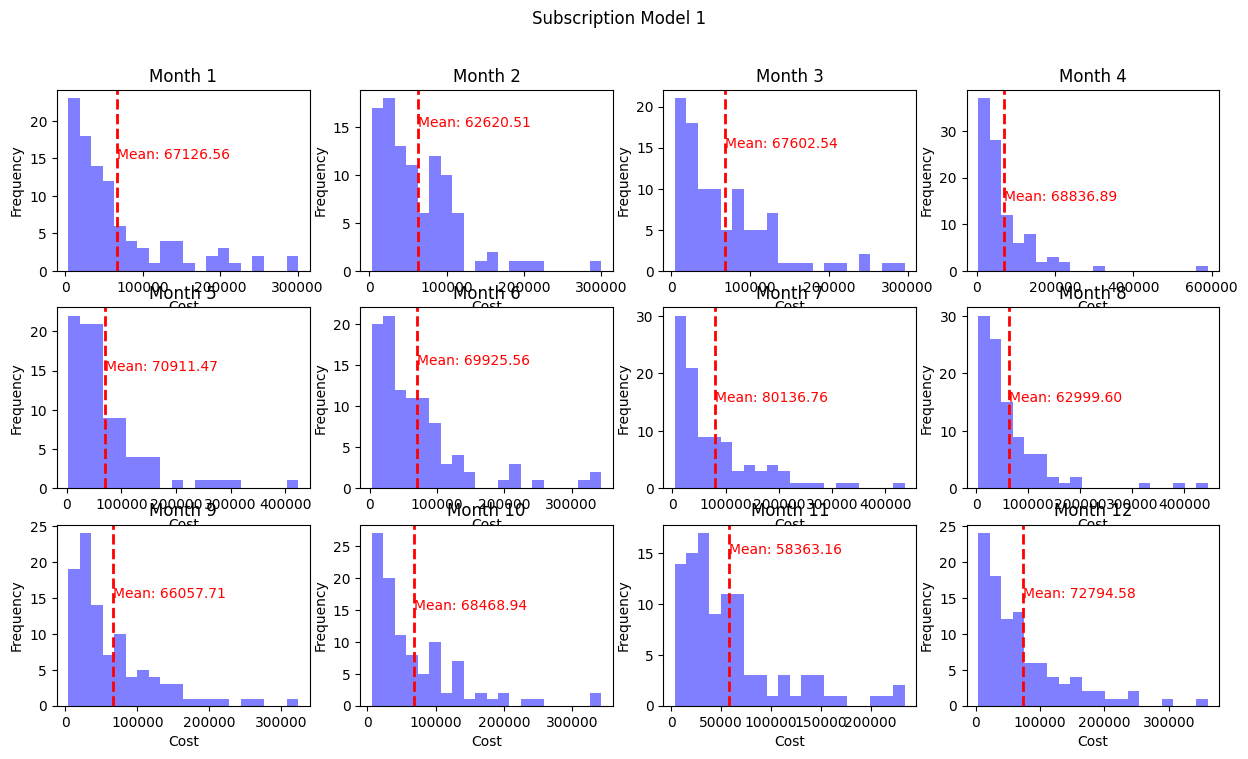

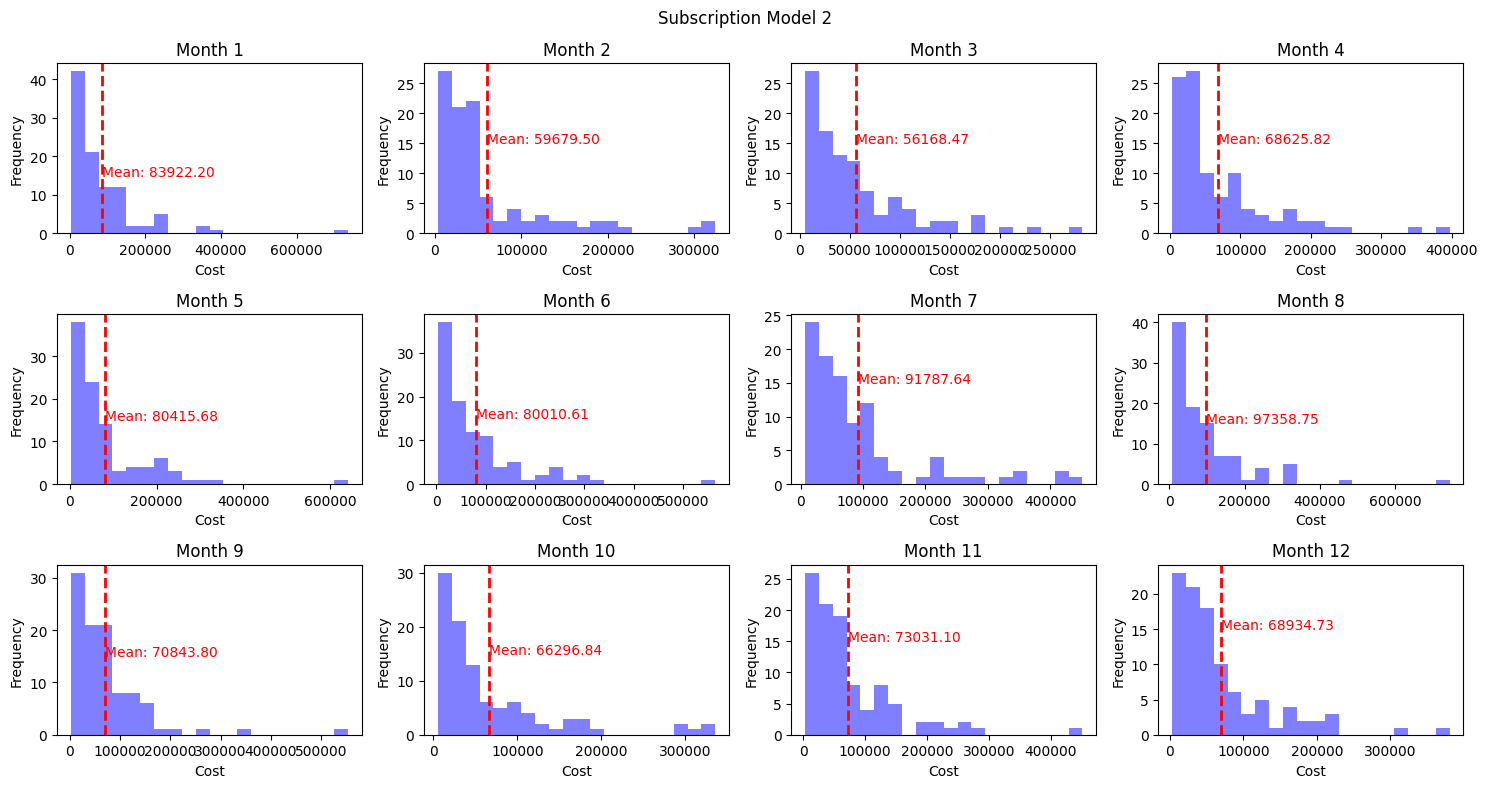

In [61]:
# convert the date of booking column to a datetime
df['date_of_booking'] = pd.to_datetime(df['date_of_booking'])

# group the data by month and sum the costs, driven kilometers, and hours rent
monthly_data = df.groupby(df['date_of_booking'].dt.to_period("M"))['total_cost_of_booking', 'driven_kilometers', 'hours_rent', 'number_of_rents'].sum()
# monthly_data = df[['date_of_booking', 'total_cost_of_booking', 'driven_kilometers', 'hours_rent', 'number_of_rents']].set_index('date_of_booking')
# convert the PeriodIndex to a datetime index
monthly_data.index = monthly_data.index.to_timestamp()

# Extract the relevant columns from the data
rents = monthly_data["number_of_rents"]
km = monthly_data["driven_kilometers"]
hours = monthly_data["hours_rent"]

# decompose the time series
result = seasonal_decompose(monthly_data["number_of_rents"], model='multiplicative')

#extract the trend and seasonal components
trend = result.trend
seasonal = result.seasonal

# aggregate trend and seasonal
aggregated_trend = trend.groupby(trend.index.month).mean()
aggregated_seasonal = seasonal.groupby(seasonal.index.month).mean()

#fit the Poisson distribution to the number of rents
poisson_params = (rents.mean(),)

#fit the Gamma distribution to the driven kilometers and hours rent
gamma_km_params = gamma.fit(km)
gamma_hours_params = gamma.fit(hours)

#simulation
np.random.seed(0) # set seed for reproducibility

#number of simulated months
n_months = 12

hourly_fee = [75, 85]
monthly_fee = [395, 0]

#initialize array to store simulated monthly costs
monthly_costs = np.zeros((n_months,100))

for sub_model in range(2):
    plt.figure(figsize=(15,8))
    for i in range(12):
        plt.subplot(3, 4, i+1)
        # simulate number of rents using Poisson distribution
        rents_sim = poisson.rvs(*poisson_params, size=100)
        # simulate driven kilometers and hours rent using Gamma distribution
        km_sim = gamma.rvs(*gamma_km_params, size=100)
        hours_sim = gamma.rvs(*gamma_hours_params, size=100)
        # use the trend and seasonal components to adjust the simulated values
        rents_sim_adj = rents_sim + aggregated_trend[i+1] + aggregated_seasonal[i+1]
        # calculate the simulated monthly cost
        monthly_costs[i] = monthly_fee[sub_model] + rents_sim_adj * (km_sim*2 + hours_sim*hourly_fee[sub_model])
        plt.hist(monthly_costs[i], bins=20, color='blue', alpha=0.5)
        plt.xlabel('Cost')
        plt.ylabel('Frequency')
        plt.title(f'Month {i+1}')
        mean = np.mean(monthly_costs[i])
        plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)
        plt.text(mean+100, 15, f"Mean: {mean:.2f}", color='r')
        plt.suptitle(f'Subscription Model {sub_model + 1}')
plt.tight_layout()
plt.show()

C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_9088\2950852409.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  self.data = self.data.groupby(self.data['date_of_booking'].dt.to_period("M"))['total_cost_of_booking', 'driven_kilometers', 'hours_rent', 'number_of_rents'].sum()


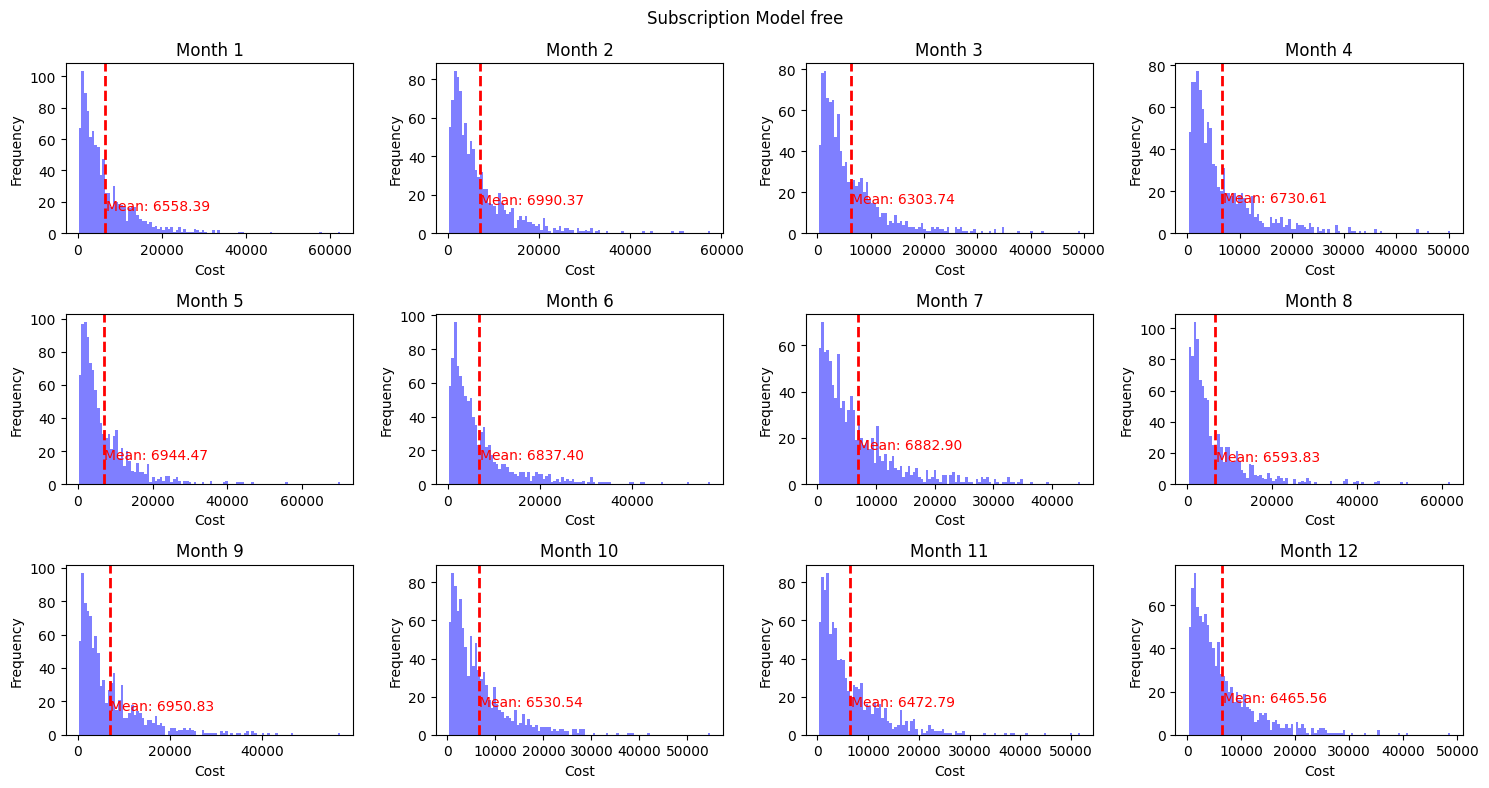

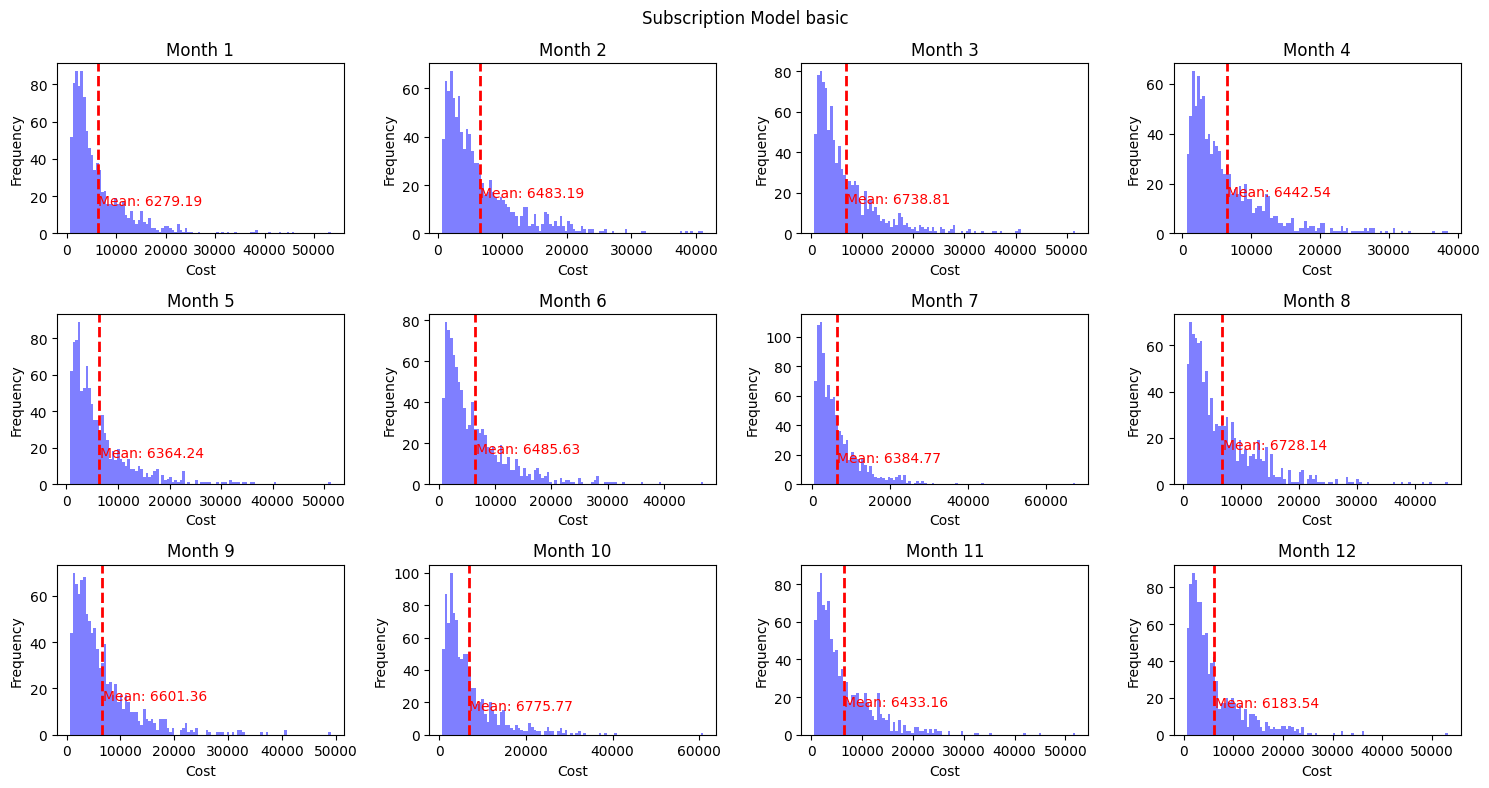

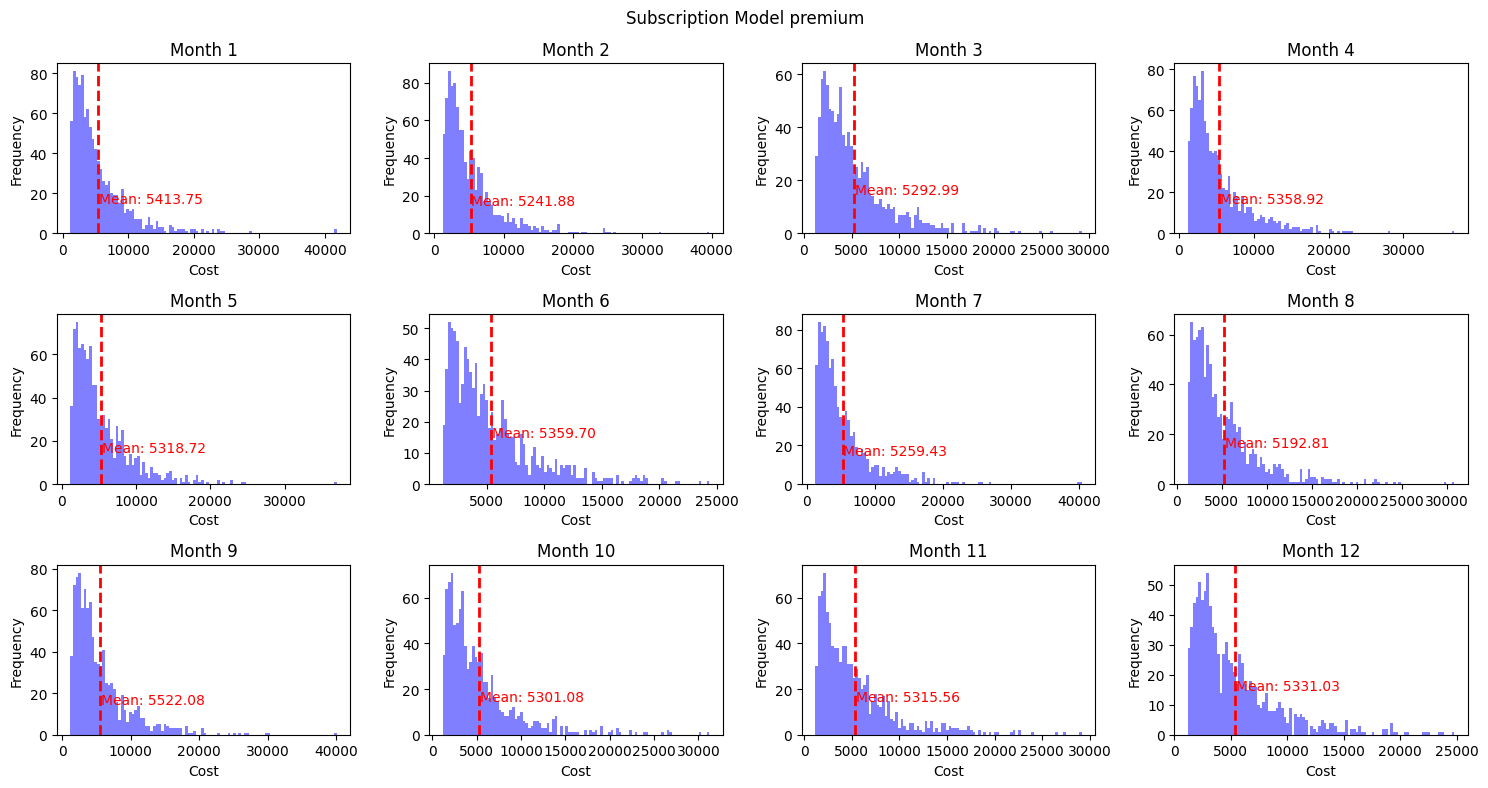

          month_1      month_2       month_3       month_4       month_5  \
0     1224.583922   691.839215   4656.762557   3456.273895   9063.307107   
1     5961.957045  8587.963503   4993.943963  10643.371910   1343.462482   
2     2734.671257  3660.523133   1344.039186   2237.130025   1233.967341   
3     1235.945628  4754.657402   1366.417927   6851.560377   2371.021159   
4     1141.489571  5261.290390   1734.835326   4270.640305  32819.198618   
..            ...          ...           ...           ...           ...   
995   1283.127011   854.839895  22553.009492   2315.302057   1227.153303   
996  20210.605549  5158.960748    992.981001   2125.529589   4745.957231   
997   5987.747572  1365.037701   1651.994525  18024.537339   8163.219285   
998   1469.596981  2394.144337   1828.690027   1381.789396  15840.362419   
999   4504.640028  6877.298668  13118.744257   2425.571648   7543.359648   

          month_6       month_7       month_8       month_9      month_10  \
0     7079

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, gamma

class CarPoolSimulation:
    def __init__(self, sample_size = 1000):
        self.sample_size = sample_size
        self.data = None
        self.hourly_fee = None
        self.monthly_fee = None
        
    def load_data(self, file_path):
        self.data = pd.read_csv(file_path, delimiter = ";", decimal = ",")
        self.data.columns = ["date_of_booking", "end_of_booking", "registration_number", "cost_of_booking", "amount_refunded", "days_rent", "hours_rent", "driven_kilometers"]
        self.data["hours_rent"] = self.data.days_rent * 24 + self.data.hours_rent
        self.data["total_cost_of_booking"] = self.data.cost_of_booking - self.data.amount_refunded
        self.data["number_of_rents"] = 1
        self.data['date_of_booking'] = pd.to_datetime(self.data['date_of_booking'])
        self.data = self.data.groupby(self.data['date_of_booking'].dt.to_period("M"))['total_cost_of_booking', 'driven_kilometers', 'hours_rent', 'number_of_rents'].sum()
        
    def run_simulation(self):
        # extract the data for each variable
        rents = self.data["number_of_rents"]
        km = self.data["driven_kilometers"]
        hours = self.data["hours_rent"]
                
        #fit the Poisson distribution to the number of rents
        poisson_params = (rents.mean(),)
        # fit the Gamma distribution to the driven kilometers and hours rent
        gamma_km_params = gamma.fit(km)
        gamma_hours_params = gamma.fit(hours)
        
        # create empty arrays to store the simulated data
        rents_sim = np.zeros((n_months, self.sample_size))
        km_sim = np.zeros((n_months, self.sample_size))
        hours_sim = np.zeros((n_months, self.sample_size))
        monthly_costs = np.zeros((n_months, self.sample_size))
        
        for i in range(12):
            # simulate the number of rents using the Poisson distribution
            rents_sim[i] = poisson.rvs(*poisson_params, size = self.sample_size)
            # simulate the driven kilometers and hours rent using the Gamma distribution
            km_sim[i] = gamma.rvs(*gamma_km_params, size = self.sample_size)
            hours_sim[i] = gamma.rvs(*gamma_hours_params, size = self.sample_size)
            # calculate the simulated monthly cost
            # monthly_costs[i] = self.monthly_fee + rents_sim[i] * (km_sim[i]*2 + hours_sim[i]*self.hourly_fee)
            monthly_costs[i] = self.monthly_fee + km_sim[i] * 2 + hours_sim[i] * self.hourly_fee
            
        return monthly_costs
    
    def plot_histograms(self, monthly_costs, bins_size = 100, alpha = 0.5):
        plt.figure(figsize=(15,8))
        
        for i in range(12):
            plt.subplot(3, 4, i+1)
            plt.hist(monthly_costs[i], bins = bins_size, color='blue', alpha = alpha)
            plt.xlabel('Cost')
            plt.ylabel('Frequency')
            plt.title(f'Month {i+1}')
            mean = np.mean(monthly_costs[i])
            plt.axvline(mean, color = 'r', linestyle = 'dashed', linewidth = 2)
            plt.text(mean + 100, 15, f"Mean: {mean:.2f}", color = 'r')
            
# create an instance of the CarPoolSimulation class
sim = CarPoolSimulation()

# load the data from a CSV file
sim.load_data("data.csv")

# define the subscription options
subscriptions = {
    "free": {"hourly_fee": 85, "monthly_fee": 0},
    "basic": {"hourly_fee": 75, "monthly_fee": 395},
    "premium": {"hourly_fee": 50, "monthly_fee": 1000}
}

# create an empty dictionary to store the dataframes
results = {}

# run the simulation for each subscription option
for subscription, fees in subscriptions.items():
    sim.hourly_fee = fees["hourly_fee"]
    sim.monthly_fee = fees["monthly_fee"]
    monthly_costs = sim.run_simulation()
    results[subscription] = pd.DataFrame(monthly_costs.T, columns = ["month_" + str(i) for i in range(1, 13)])
    
    # plot the histograms
    sim.plot_histograms(monthly_costs)
    plt.suptitle(f'Subscription Model {subscription}')
    plt.tight_layout()
    plt.show()
    
# access the dataframe for the basic subscription
print(results["basic"])


In [116]:
# calculate the average annual cost for each subscription
annual_costs = {}
for subscription, df in results.items():
    annual_costs[subscription] = df.mean().sum()

# find the cheapest subscription
cheapest_subscription = min(annual_costs, key=annual_costs.get)
print(f"The cheapest subscription is {cheapest_subscription}")

The cheapest subscription is premium


In [117]:
cheapest_cost = annual_costs[cheapest_subscription]
for subscription, cost in annual_costs.items():
    if subscription != cheapest_subscription:
        difference = cheapest_cost - cost
        print(f"{subscription} is {difference:.2f} SEK cheaper than {cheapest_subscription}")


free is -16334.57 SEK cheaper than premium
basic is -12629.60 SEK cheaper than premium


In [119]:
fixed_annual_cost = 7500*12
probabilities = {}
for subscription, df in results.items():
    exceeded_probability = df[df.sum(axis=1) > fixed_annual_cost].shape[0] / df.shape[0]
    probabilities[subscription] = exceeded_probability

for subscription, prob in probabilities.items():
    print(f"The probability of {subscription} exceeding the fixed annual cost of {fixed_annual_cost} SEK is {prob:.2%}")


The probability of free exceeding the fixed annual cost of 90000 SEK is 30.40%
The probability of basic exceeding the fixed annual cost of 90000 SEK is 21.90%
The probability of premium exceeding the fixed annual cost of 90000 SEK is 5.20%


In [125]:
cutoff_values = [50000, 55000, 60000, 65000, 70000]
prob_results = []
for cutoff in cutoff_values:
    prob = {}
    for subscription, df in results.items():
        exceeded_probability = df[df.sum(axis=1) > cutoff].shape[0] / df.shape[0]
        prob[subscription] = exceeded_probability
    prob_results.append(prob)

df_prob = pd.DataFrame(prob_results, columns=["free", "basic", "premium"], index=cutoff_values)
print(df_prob)


        free  basic  premium
50000  0.924  0.945    0.832
55000  0.875  0.883    0.703
60000  0.810  0.804    0.578
65000  0.727  0.712    0.435
70000  0.629  0.611    0.328


ValueError: Shape of passed values is (5, 1), indices imply (5, 3)

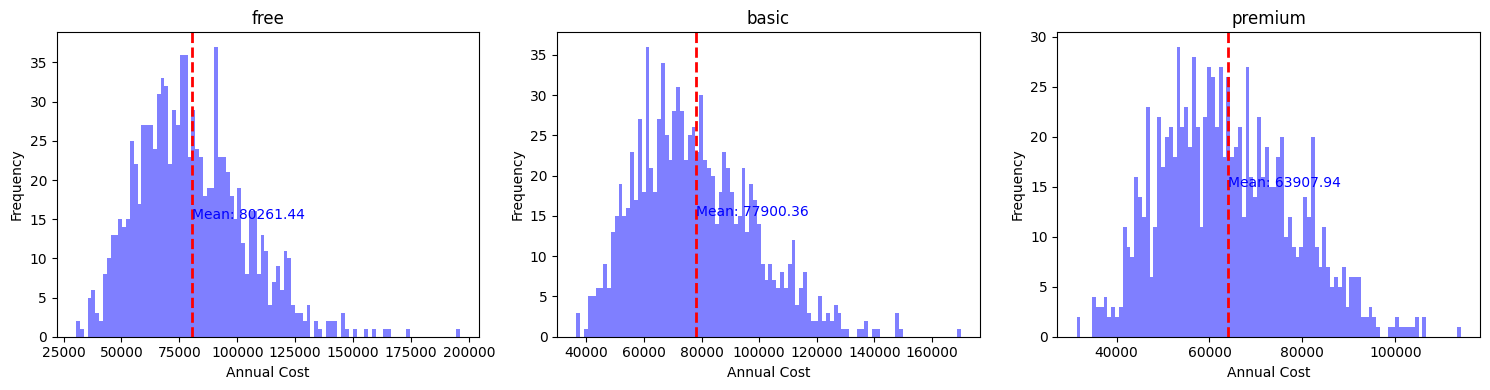

In [133]:
# define the fixed annual costs
cut_off_values = [20000, 22000, 25000, 27000, 30000]

# create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4), tight_layout=True)

prob_results = []
# iterate through the subscriptions
for i, (subscription, df) in enumerate(results.items()):
    # calculate the probability of the annual cost being exceeded for each cut-off value
    probabilities = {}
    for cut_off in cut_off_values:
        exceeded_probability = df[df.sum(axis=1) > cut_off].shape[0] / df.shape[0]
        probabilities[cut_off] = exceeded_probability
    # add a new row to the dataframe for the subscription
    prob_df[subscription] = pd.Series(probabilities)
    # create a histogram for the subscription
    axs[i].hist(df.sum(axis=1), bins=100, color='blue', alpha=0.5)
    axs[i].set_xlabel('Annual Cost')
    axs[i].set_ylabel('Frequency')
    axs[i].set_title(subscription)
    mean = np.mean(df.sum(axis=1))
    axs[i].axvline(mean, color='r', linestyle='dashed', linewidth=2)
    axs[i].text(mean + 100, 15, f"Mean: {mean:.2f}", color='b')

# create a dataframe to store the probabilities
prob_df = pd.DataFrame.from_dict(probabilities, orient='index', columns=results.keys())


In [131]:
probabilities

{20000: 1.0, 22000: 1.0, 25000: 1.0, 27000: 1.0, 30000: 1.0}

In [ ]:
# load the data into a pandas dataframe
df = pd.read_csv("data.csv", delimiter = ";", decimal = ",")
df.columns = ["date_of_booking", "end_of_booking", "registration_number", "cost_of_booking", "amount_refunded", "days_rent", "hours_rent", "driven_kilometers"]
df["hours_rent"] = df.days_rent * 24 + df.hours_rent
df["total_cost_of_booking"] = df.cost_of_booking - df.amount_refunded
df["number_of_rents"] = 1

# convert the date of booking column to a datetime
df['date_of_booking'] = pd.to_datetime(df['date_of_booking'])

# group the data by month and sum the costs, driven kilometers, and hours rent
monthly_data = df.groupby(df['date_of_booking'].dt.to_period("M"))['total_cost_of_booking', 'driven_kilometers', 'hours_rent', 'number_of_rents'].sum()
# convert the PeriodIndex to a datetime index
monthly_data.index = monthly_data.index.to_timestamp()

# define the hourly fee and monthly fee for the two subscription models
hourly_fee = [75, 85]
monthly_fee = [395, 0]

all_results = []
for sub_model in range(2):
    # create an instance of the class
    sim = CarPoolSimulation(monthly_data, hourly_fee[sub_model], monthly_fee[sub_model])
    # run the simulation
    monthly_costs = sim.run_simulation()
    all_results.append(monthly_costs)
    # plot the histograms
    sim.plot_histograms(monthly_costs)
    plt.suptitle(f'Subscription Model {sub_model + 1}')
    plt.tight_layout()
    plt.show()

In [91]:
# Sum up the simulated monthly costs for each subscription model
annual_costs = [sum(result) for result in all_results]

# Compare the annual distributions using a t-test
from scipy.stats import ttest_ind
t_stat, p_value = ttest_ind(annual_costs[0], annual_costs[1])
print("t-statistic: ", t_stat)
print("p-value: ", p_value)

# or compare the annual distributions using a Kolmogorov-Smirnov test
from scipy.stats import ks_2samp
ks_stat, p_value = ks_2samp(annual_costs[0], annual_costs[1])
print("Kolmogorov-Smirnov statistic: ", ks_stat)
print("p-value: ", p_value)


t-statistic:  -4.694353900391282
p-value:  2.856163492176039e-06
Kolmogorov-Smirnov statistic:  0.098
p-value:  0.00013349301651925088


In [92]:
# Compute the mean and standard deviation of the annual costs for each subscription model
mean_costs = [np.mean(costs) for costs in annual_costs]
std_costs = [np.std(costs) for costs in annual_costs]

# Print the mean and standard deviation of the annual costs for each subscription model
for i in range(2):
    print(f'Subscription Model {i+1}')
    print(f'Mean: {mean_costs[i]:.2f}')
    print(f'Standard deviation: {std_costs[i]:.2f}')


Subscription Model 1
Mean: 77149.30
Standard deviation: 21259.51
Subscription Model 2
Mean: 81806.55
Standard deviation: 23050.05


In [93]:
# Compute the probability of the annual cost for each subscription model exceeding a certain threshold
for i in range(2):
    prob = sum(annual_costs[i] > mean_costs[i-1]) / len(annual_costs[i])
    print(f'Probability of exceeding the cost of Subscription Model {i%2+1} is {prob:.2f}')


Probability of exceeding the cost of Subscription Model 1 is 0.37
Probability of exceeding the cost of Subscription Model 2 is 0.54


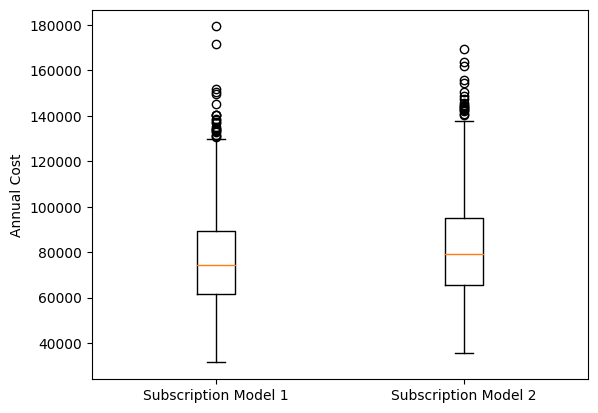

In [94]:
import matplotlib.pyplot as plt

# Plot the annual costs for each subscription model using a box-plot
plt.boxplot(annual_costs, labels=['Subscription Model 1', 'Subscription Model 2'])
plt.ylabel('Annual Cost')
plt.show()
